# Imports

In [ ]:
!pip install scikit-learn
!pip install scikit-multilearn
!pip install -q datasets
!pip install -q kaggle
!pip install torch transformers
!pip install faiss-gpu faiss-cpu

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import torch
import skmultilearn
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split
from datasets import Dataset, DatasetDict
from collections import defaultdict
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoTokenizer, AutoModel
from transformers import GPT2Tokenizer, GPT2Model, AutoConfig, AutoModelForSequenceClassification

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 33.3 MB/s eta 0:00:00


### Kaggle Imports

In [ ]:
# Upload Kaggle API token
from google.colab import files
files.upload()  # This will prompt you to upload your kaggle.json file

# Create Kaggle directory and copy the API token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions


Saving kaggle.json to kaggle.json


### Download dataset from Kaggle

In [ ]:
# Download the dataset
!kaggle datasets download -d bayes2003/emails-for-spam-or-ham-classification-trec-2007

# Unzip the dataset
!unzip emails-for-spam-or-ham-classification-trec-2007.zip


Dataset URL: https://www.kaggle.com/datasets/bayes2003/emails-for-spam-or-ham-classification-trec-2007
License(s): ODbL-1.0
100% 482M/483M [00:24<00:00, 23.5MB/s]
100% 483M/483M [00:24<00:00, 20.7MB/s]
Archive:  emails-for-spam-or-ham-classification-trec-2007.zip
  inflating: email_origin.csv        
  inflating: email_text.csv          
  inflating: trec07p.tgz             


### a) Liste os campos que compõem cada registro

In [ ]:
dataframe = pd.read_csv('email_text.csv')
dataframe.head()

fields = dataframe.columns.tolist()
print("Fields that compose each record:", fields)

Fields that compose each record: ['label', 'text']


### b) Liste os labels das classes existentes


In [ ]:
# 0 for ham and 1 for spam
labels = dataframe['label'].unique()
print("Labels of existing classes", labels)

Labels of existing classes [1 0]


### c) Liste a quantidade de registros que não contenham label, que contenham um label, dois labels, até o máximo de labels existentes.

<ipython-input-6-11eac73fe815>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label Status', y='Count', data=label_counts, palette='pastel')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


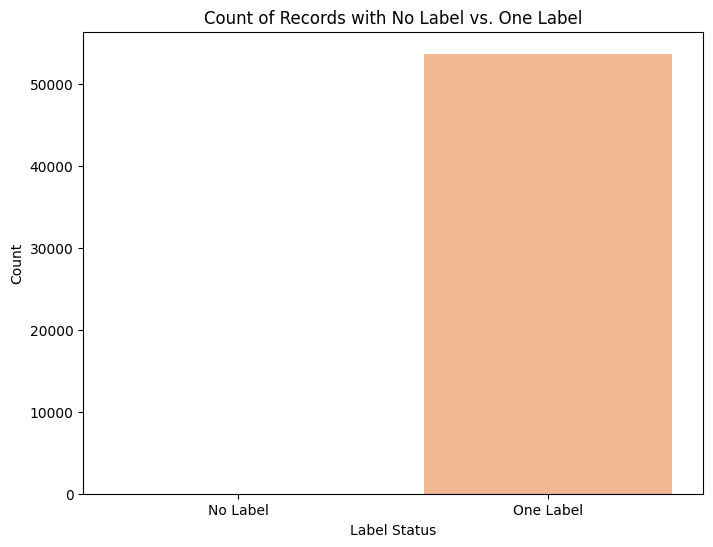

In [ ]:
no_label_count = dataframe['label'].isna().sum()
one_label_count = dataframe['label'].notna().sum()

label_counts = pd.DataFrame({'Label Status': ['No Label', 'One Label'], 'Count': [no_label_count, one_label_count]})

plt.figure(figsize=(8,6))
sns.barplot(x='Label Status', y='Count', data=label_counts, palette='pastel')
plt.title('Count of Records with No Label vs. One Label')
plt.ylabel('Count')
plt.show()

### d) Liste a quantidade de registros associados a cada label/classe existente

<ipython-input-7-f1dcfa3bc3ed>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Label', y='Count', data=label_counts_df, palette='pastel')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


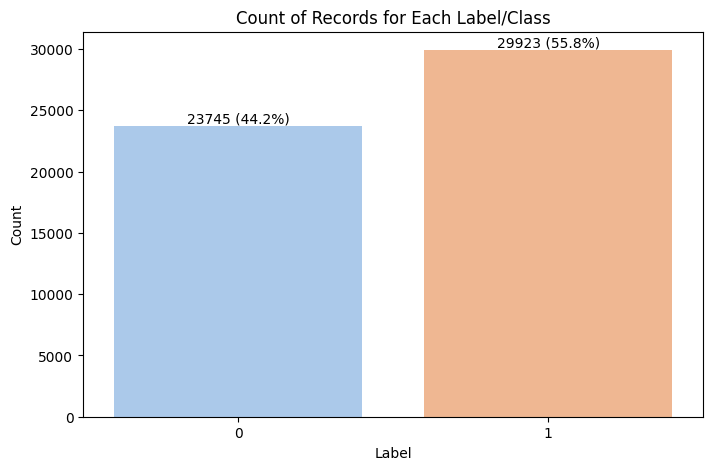

In [ ]:
label_counts = dataframe['label'].value_counts()

# Create a DataFrame for plotting
label_counts_df = pd.DataFrame(label_counts).reset_index()
label_counts_df.columns = ['Label', 'Count']

# Calculate total count
total_count = label_counts_df['Count'].sum()

# Calculate percentage
label_counts_df['Percentage'] = (label_counts_df['Count'] / total_count) * 100

# Plot
plt.figure(figsize=(8, 5))
bar_plot = sns.barplot(x='Label', y='Count', data=label_counts_df, palette='pastel')
plt.title('Count of Records for Each Label/Class')
plt.ylabel('Count')

# Annotate each bar with the count and percentage
for p in bar_plot.patches:
    count = int(p.get_height())
    # Use the Label index to find the correct percentage
    label_index = label_counts_df.index[label_counts_df['Label'] == int(p.get_x() + p.get_width() / 2)]
    percentage = label_counts_df.loc[label_index, 'Percentage'].values[0] if label_index.size > 0 else 0
    bar_plot.annotate(f'{count} ({percentage:.1f}%)',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom')

plt.show()


### e) Liste a quantidade de registros com labels/classes e sem labels/classes


<ipython-input-8-21dae93707b9>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Label Status', y='Count', data=final_label_counts, palette='pastel')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


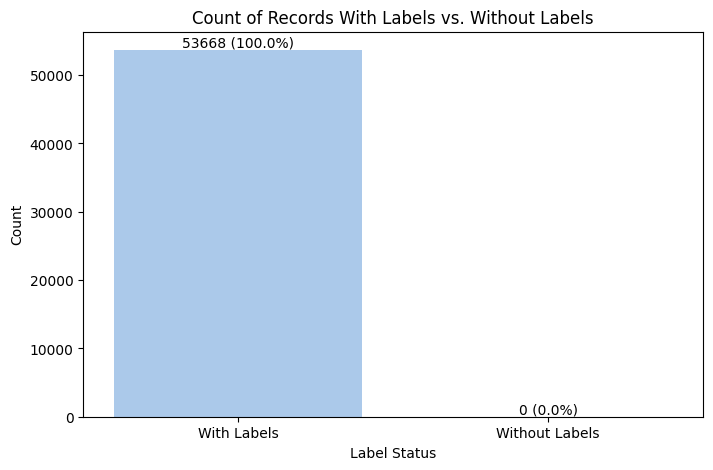

In [ ]:
with_labels_count = dataframe['label'].notna().sum()
without_labels_count = dataframe['label'].isna().sum()

# Create a DataFrame for counts
final_label_counts = pd.DataFrame({
    'Label Status': ['With Labels', 'Without Labels'],
    'Count': [with_labels_count, without_labels_count]
})

# Calculate total count for percentage calculation
total_count = final_label_counts['Count'].sum()

# Calculate percentage
final_label_counts['Percentage'] = (final_label_counts['Count'] / total_count) * 100

# Plot
plt.figure(figsize=(8, 5))
bar_plot = sns.barplot(x='Label Status', y='Count', data=final_label_counts, palette='pastel')

plt.title('Count of Records With Labels vs. Without Labels')
plt.ylabel('Count')

# Annotate each bar with the count and percentage
for i, p in enumerate(bar_plot.patches):
    count = int(p.get_height())
    percentage = final_label_counts['Percentage'].iloc[i]  # Accessing percentage by index
    bar_plot.annotate(f'{count} ({percentage:.1f}%)',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom')

plt.show()

### 4) Identifique quais labels/classes serão utilizados na atividade de classificação a ser realizada. Aplique um filtro apropriado para uso destes registros na atividade.

### 5) Crie uma nova coluna no dataframe do Pandas que você está utilizando para indicar se o registro possui label ou não.

### 6) Caso dois ou mais campos contenham informação textual de interesse para a análise, avalie a possibilidade de concatená-los em um único campo.

## Sampling the data

Random state for replicability = 42

Number of spam emails: 1000
Number of ham emails: 9000
Percentage of spam emails: 10.00%
Percentage of ham emails: 90.00%


<ipython-input-9-62e602d3dc85>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=labels, y=counts, palette='Blues')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


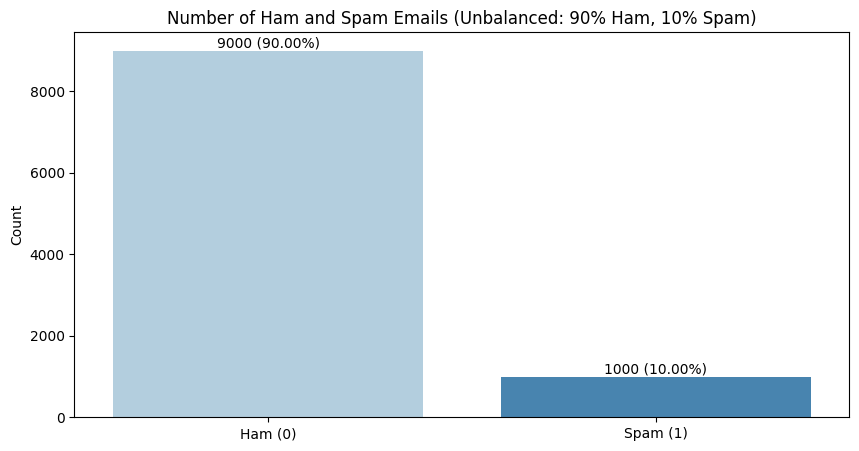

Shape of the cleaned DataFrame: (10000, 2)


In [ ]:
# Separate the spam and ham classes
spam_dataframe = dataframe[dataframe['label'] == 1]
ham_dataframe = dataframe[dataframe['label'] == 0]

# Take 90% Ham and 10% Spam from the dataset
ham_count = 9000  # 90% of 10,000
spam_count = 1000  # 10% of 10,000

# Select the samples
ham_sample = ham_dataframe.sample(n=ham_count, random_state=42)
spam_sample = spam_dataframe.sample(n=spam_count, random_state=42)

unbalanced_df = pd.concat([ham_sample, spam_sample])

# Shuffle the data to avoid ordering bias
unbalanced_df = unbalanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

spam_count = unbalanced_df['label'].value_counts()[1]
ham_count = unbalanced_df['label'].value_counts()[0]

total_emails = len(unbalanced_df)
spam_percentage = (spam_count / total_emails) * 100
ham_percentage = (ham_count / total_emails) * 100

# Print the new distribution
print(f"Number of spam emails: {spam_count}")
print(f"Number of ham emails: {ham_count}")
print(f"Percentage of spam emails: {spam_percentage:.2f}%")
print(f"Percentage of ham emails: {ham_percentage:.2f}%")

# Prepare data for plotting
labels = ['Ham (0)', 'Spam (1)']
counts = [ham_count, spam_count]
percentages = [ham_percentage, spam_percentage]

# Plot the absolute counts
plt.figure(figsize=(10, 5))
bar_plot = sns.barplot(x=labels, y=counts, palette='Blues')
plt.title('Number of Ham and Spam Emails (Unbalanced: 90% Ham, 10% Spam)')
plt.ylabel('Count')

# Annotate bars with counts and percentages
for p in bar_plot.patches:
    count = int(p.get_height())
    percentage = (count / total_emails) * 100
    bar_plot.annotate(f'{count} ({percentage:.2f}%)',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom')

plt.show()

print(f"Shape of the cleaned DataFrame: {unbalanced_df.shape}")


### 7) Identifique possíveis registros duplicados e remova-os.

In [ ]:
# Check the number of records before dropping duplicates
len_before = len(unbalanced_df)

# Drop duplicates based on the 'text' column
unbalanced_df = unbalanced_df.drop_duplicates(subset="text")

# Calculate and print the percentage of duplicates removed
print(f"Removed {(len_before - len(unbalanced_df)) / len_before:.2%} duplicates.")


Removed 0.00% duplicates.


### 8) Apresente um gráfico para mostrar a distribuição de quantidade de palavras por registro.

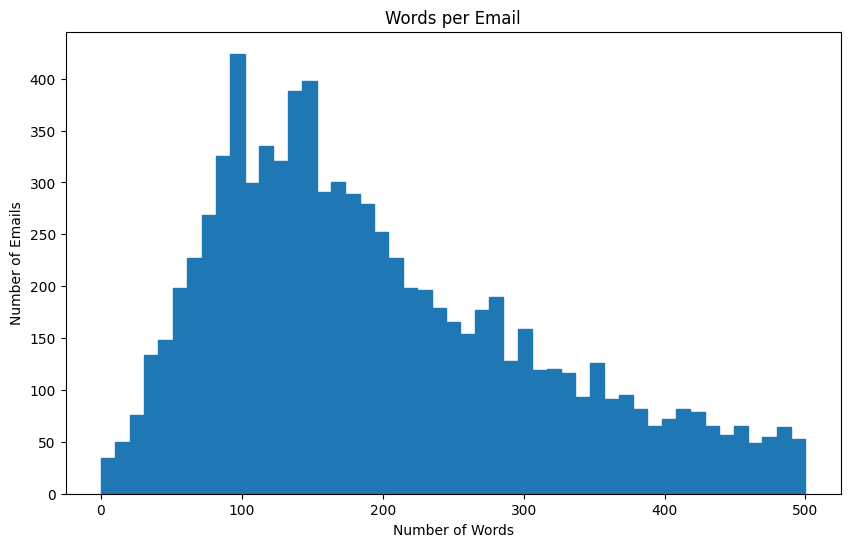

Number of records: 10000


In [ ]:
# Calculate the number of words per email
word_counts = unbalanced_df['text'].str.split().apply(len)

# Create a histogram
plt.figure(figsize=(10, 6))
word_counts.hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0")
plt.title("Words per Email")
plt.xlabel("Number of Words")
plt.ylabel("Number of Emails")
plt.show()

number_of_rows = len(unbalanced_df)
print(f"Number of records: {number_of_rows}")


### 9) Utilize a biblioteca Scikit-multilearn para criar os conjuntos de registros para treinamento, validação e teste.

In [ ]:
# Assuming your DataFrame unbalanced_df has a 'label' column
# Convert the 'label' column into a list of lists for MultiLabelBinarizer
unbalanced_df['labels'] = unbalanced_df['label'].apply(lambda x: [x])  # Convert to list

# Create a 'split' column (Example: Randomly assign labeled and unlabeled)
np.random.seed(0)  # For reproducibility
unbalanced_df['split'] = np.where(np.random.rand(len(unbalanced_df)) < 0.5, 'labeled', 'unlabeled')

# Transform labels using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
all_labels = unbalanced_df['labels'].tolist()  # Now this will contain lists of labels
mlb.fit(all_labels)  # Fit to all possible labels

# Function for balanced splitting
def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)  # Create indices
    labels = mlb.transform(df["labels"])  # Transform labels to binary
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels, test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]

# Prepare the DataFrame for labeled and unlabeled data
df_clean = unbalanced_df[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

# Create training, validation, and test sets
np.random.seed(0)  # Set seed for reproducibility
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

# Create a DatasetDict with all splits
ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))
})

# Optional: Display the sizes of the created datasets
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_valid)}")
print(f"Test set size: {len(df_test)}")
print(f"Unlabeled set size: {len(df_unsup)}")


print(unbalanced_df.columns)

Training set size: 2532
Validation set size: 1265
Test set size: 1267
Unlabeled set size: 4936
Index(['label', 'text', 'labels', 'split'], dtype='object')


### 10) Crie os training slices do seu dataset.

In [ ]:
# Set random seed for reproducibility
np.random.seed(0)

# Create a pool of all indices from the training dataset
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)  # Create an array of indices
indices_pool = all_indices.copy()  # Copy indices to maintain original for splitting
labels = mlb.transform(ds["train"]["labels"])  # Transform labels into a binary format

# Define different training sample sizes you want to experiment with
train_samples = [8, 16, 32, 64, 128]  # Sample sizes to create slices
train_slices, last_k = [], 0  # Lists to store the slices and keep track of the last size

# Create slices of training data
for i, k in enumerate(train_samples):
    # Split off the necessary samples to fill the gap to the next split size
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k - last_k) / len(labels)  # Calculate the required proportion for the next size
    )

    last_k = k  # Update the last sample size

    # Append the new slice to the list of training slices
    if i == 0:
        train_slices.append(new_slice)  # For the first slice, just append the new slice
    else:
        train_slices.append(np.concatenate((train_slices[-1], new_slice)))  # Concatenate with the last slice

# Add the full dataset as the last slice
train_slices.append(all_indices)
train_samples.append(len(ds["train"]))  # Append the full dataset size

# Squeeze the training slices to remove unnecessary dimensions
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

# Print target and actual split sizes to verify
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 64, 128, 2532]
Actual split sizes:
[8, 16, 32, 64, 128, 2532]


### 11) Implemente o Naive Bayesline e apresente os gráficos para Micro e Macro F1 score.

Map:   0%|          | 0/2532 [00:00<?, ? examples/s]

Map:   0%|          | 0/1265 [00:00<?, ? examples/s]

Map:   0%|          | 0/1267 [00:00<?, ? examples/s]

Map:   0%|          | 0/4936 [00:00<?, ? examples/s]

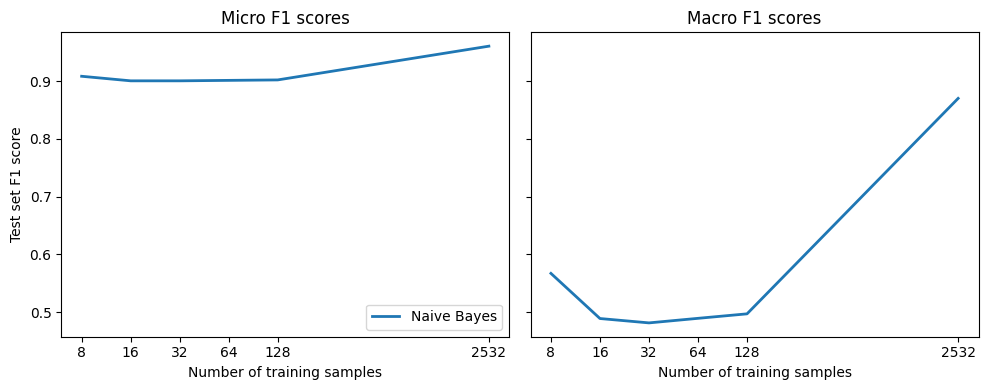

In [ ]:
# Prepare labels function
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

# Map labels to prepare the dataset
ds = ds.map(prepare_labels, batched=True)

# Initialize dictionaries to store scores
macro_scores, micro_scores = defaultdict(list), defaultdict(list)

# Training the Naive Bayes classifier and evaluating performance
for train_slice in train_slices:
    # Get the training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])

    # Use a simple Count Vectorizer to encode texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])

    # Create and train the Naive Bayes model using Binary Relevance
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)

    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True
    )

    # Store metrics
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

# Function to plot Micro and Macro F1 scores
def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")

    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()

    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")


### 12) Utilize o recurso de embeddings, o gpt-2 disponível no Hugging Faces em "miguelvictor/python-gpt2-large" e os recursos oferecidos pelo FAISS para apresentar e discutir os resultados de micro e macro F1 score com o dataset por você selecionado e pré-processado nas etapas anteriores.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt).to(device)

def mean_pooling(model_output, attention_mask):
    # Extract the token embeddings
    token_embeddings = model_output[0]
    # Compute the attention mask
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float())
    # Sum the embeddings, but ignore masked tokens
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # Return the average as a single vector
    return sum_embeddings / sum_mask

def embed_text(examples):
    # Move the model to GPU if available
    model.to('cuda' if torch.cuda.is_available() else 'cpu')

    # Move the tokenizer inputs to the same device
    inputs = tokenizer(examples["text"], padding=True, truncation=True,
                       max_length=128, return_tensors="pt").to('cuda' if torch.cuda.is_available() else 'cpu')

    with torch.no_grad():
        model_output = model(**inputs)

    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}  # Move back to CPU for numpy conversion

cuda


In [ ]:
# hide_output
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)

Map:   0%|          | 0/2532 [00:00<?, ? examples/s]

Map:   0%|          | 0/1265 [00:00<?, ? examples/s]

Map:   0%|          | 0/1267 [00:00<?, ? examples/s]

In [ ]:
# hide_output
embs_train.add_faiss_index("embedding")

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'labels', 'label_ids', 'embedding'],
    num_rows: 2532
})

In [ ]:
i, k = 0, 3 # Select the first query and 3 nearest neighbors
rn, nl = "\r\n\r\n", "\n" # Used to remove newlines in text for compact display

query =  np.array(embs_valid[i]["embedding"], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k)

print(f"QUERY LABELS: {embs_valid[i]['labels']}")
print(f"QUERY TEXT:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n")
print("="*50)
print(f"Retrieved documents:")
for score, label, text in zip(scores, samples["labels"], samples["text"]):
    print("="*50)
    print(f"TEXT:\n{text[:200].replace(rn, nl)} [...]")
    print(f"SCORE: {score:.2f}")
    print(f"LABELS: {label}")

QUERY LABELS: [0]
QUERY TEXT:
parrot ml please review escapenumber this for me blocks further submissions against libra ry c as i need to know what i will be basing against cheers mike mattie codermattie gmail com [...]

Retrieved documents:
TEXT:
cody hamilton edwards com wrote would this function help http www csm ornl gov frome es rrmhex mhanalysis txt regards cody i think so thank you cody if you have time would you mind defining probably o [...]
SCORE: 62.22
LABELS: [0]
TEXT:
yes sorry i've confused inverse cdf with complementary cdf marco on escapenumber escapenumber escapenumber maitra iastate edu wrote doesn't quantile do what you want hth ranjan hi all ecdf is the empi [...]
SCORE: 65.13
LABELS: [0]
TEXT:
lisa can we expect to see r used exclusively i would hope during your demonstration learning how data mining models work the inputs the outputs and the nature of the predictive mechanism only makes se [...]
SCORE: 67.78
LABELS: [0]


In [ ]:
def get_sample_preds(sample, m):
    return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)

def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=4):
    max_k = min(len(ds_train), max_k)
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k):
        for m in range(1, k + 1):
            _, samples = ds_train.get_nearest_examples_batch("embedding",
                                                             valid_queries, k=k)
            y_pred = np.array([get_sample_preds(s, m) for s in samples])
            clf_report = classification_report(valid_labels, y_pred,
                target_names=mlb.classes_, zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
    return perf_micro, perf_macro

In [ ]:
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)

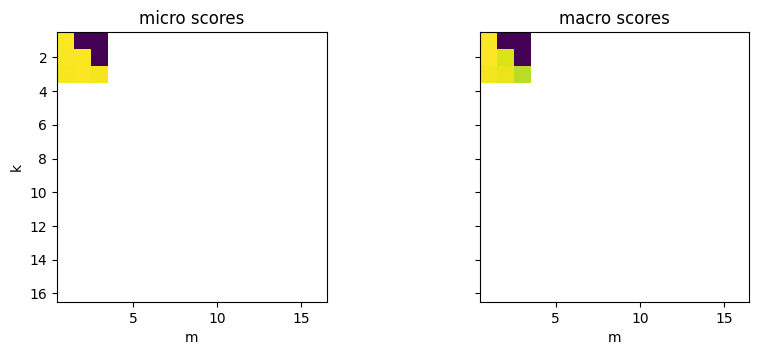

In [ ]:
# Plotting the performance
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)
ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0, ax1]:
    ax.set_xlim([0.5, 17 - 0.5])
    ax.set_ylim([17 - 0.5, 0.5])
    ax.set_xlabel("m")
plt.show()

In [ ]:
# Get best k, m values based on validation performance
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"Best k: {k}, best m: {m}")

Best k: 1, best m: 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

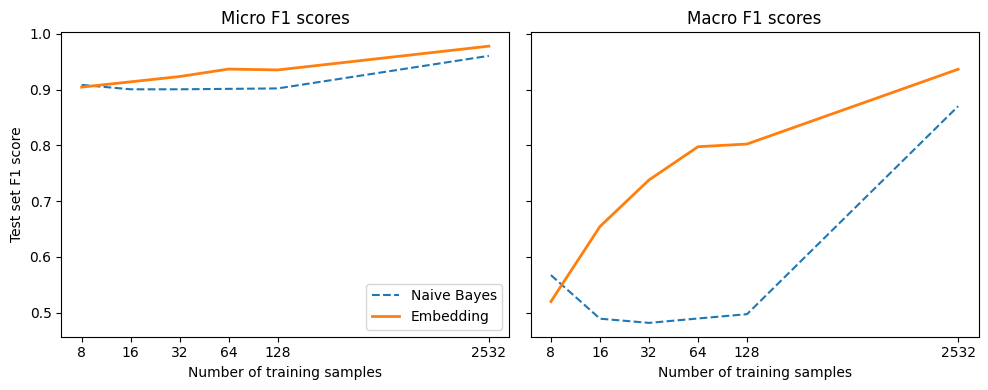

In [ ]:
# Drop the FAISS index for memory optimization
embs_train.drop_index("embedding")

test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype=np.float32)

for train_slice in train_slices:
    # Create FAISS index from training slice
    embs_train_tmp = embs_train.select(train_slice)
    embs_train_tmp.add_faiss_index("embedding")

    # Get best k, m values with validation set
    perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)

    # Get predictions on the test set
    _, samples = embs_train_tmp.get_nearest_examples_batch("embedding", test_queries, k=int(k))
    y_pred = np.array([get_sample_preds(s, m) for s in samples])

    # Evaluate predictions
    clf_report = classification_report(test_labels, y_pred,
        target_names=mlb.classes_, zero_division=0, output_dict=True)
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])

# Plot performance metrics
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")